In [1]:
import torch

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 13096667.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()
model.to(device)  # Move model to GPU if available

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Epoch [1/10], Train Loss: 0.0998, Train Acc: 0.9657, Test Loss: 1.4822, Test Acc: 0.7149
Epoch [2/10], Train Loss: 0.0796, Train Acc: 0.9726, Test Loss: 1.6092, Test Acc: 0.7091
Epoch [3/10], Train Loss: 0.0689, Train Acc: 0.9768, Test Loss: 1.6659, Test Acc: 0.7143
Epoch [4/10], Train Loss: 0.0666, Train Acc: 0.9775, Test Loss: 1.8948, Test Acc: 0.7117
Epoch [5/10], Train Loss: 0.0608, Train Acc: 0.9794, Test Loss: 1.8880, Test Acc: 0.7206
Epoch [6/10], Train Loss: 0.0542, Train Acc: 0.9812, Test Loss: 1.9921, Test Acc: 0.7080
Epoch [7/10], Train Loss: 0.0562, Train Acc: 0.9807, Test Loss: 2.0482, Test Acc: 0.7096
Epoch [8/10], Train Loss: 0.0484, Train Acc: 0.9829, Test Loss: 2.0608, Test Acc: 0.7150
Epoch [9/10], Train Loss: 0.0404, Train Acc: 0.9864, Test Loss: 2.1639, Test Acc: 0.7113
Epoch [10/10], Train Loss: 0.0558, Train Acc: 0.9811, Test Loss: 2.2386, Test Acc: 0.7072


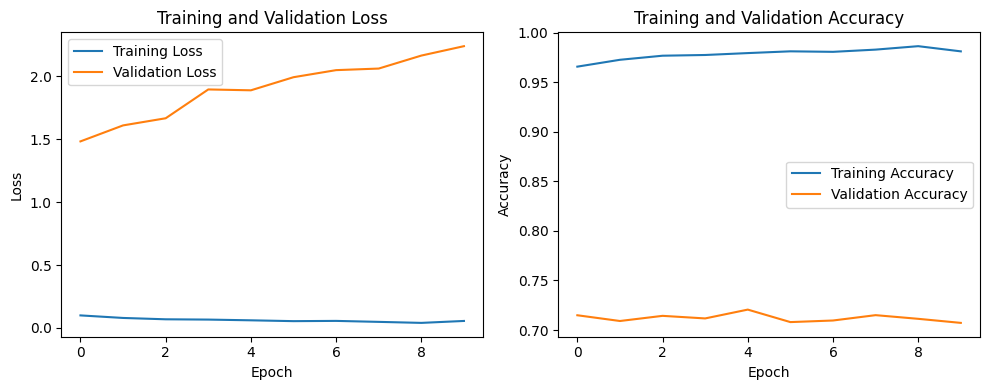

Final Test Accuracy: 70.72%


In [8]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define lists to store metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with visualization
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate on test set
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and accuracy
    test_loss /= len(testloader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Print progress and update learning rate if needed
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plotting training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation on test set
print(f'Final Test Accuracy: {test_acc * 100:.2f}%')


In [15]:
class_correct = list(0. for _ in range(10))
class_total = list(0. for _ in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

Accuracy of plane: 70.60%
Accuracy of car: 77.00%
Accuracy of bird: 69.90%
Accuracy of cat: 52.50%
Accuracy of deer: 70.60%
Accuracy of dog: 61.30%
Accuracy of frog: 78.00%
Accuracy of horse: 71.40%
Accuracy of ship: 82.60%
Accuracy of truck: 73.30%


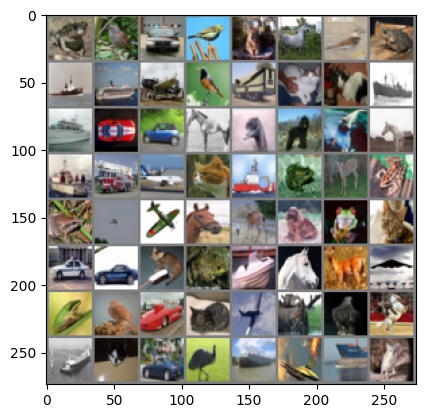

GroundTruth:   frog  bird   car  bird
Predicted:   frog  bird  ship  bird


In [18]:
# Get another batch of test images and labels
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

# Make predictions
images = images.to(device)  # Move images to GPU if available
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()] for j in range(4)))

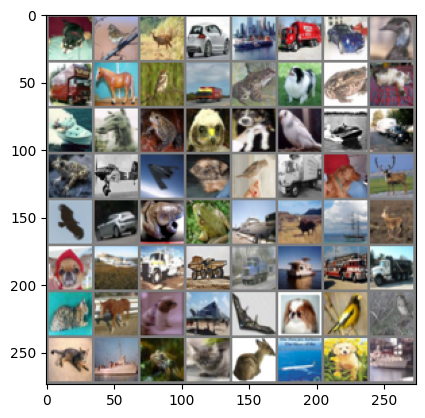

GroundTruth:    dog  bird  deer   car
Predicted:    dog plane  deer   car


In [19]:
# Get another batch of test images and labels
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

# Make predictions
images = images.to(device)  # Move images to GPU if available
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()] for j in range(4)))

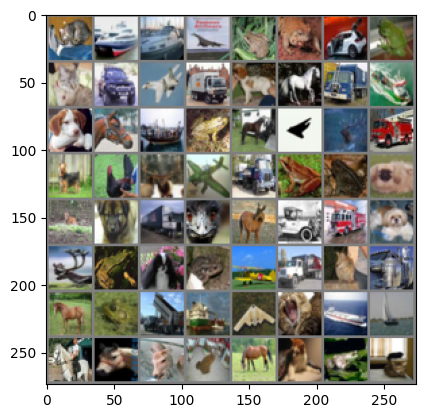

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane


In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Function to show an image tensor
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some test images and labels
dataiter = iter(testloader)
images, labels = next(dataiter)  # Fetches the next batch

# Show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

# Move images and labels to GPU if available
images, labels = images.to(device), labels.to(device)

# Predict the labels
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()]
                              for j in range(4)))

### Questions

#### What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.

    A Convolutional Neural Network (CNN) is a type of deep learning model primarily used for processing grid-like data such as images. Its key components and differences from fully connected neural networks (FCNNs) are:


Key Components of a CNN

    Convolutional Layers: Apply filters (kernels) to the input to create feature maps, capturing local patterns.

    Activation Functions: Non-linear functions like ReLU applied after convolution to introduce non-linearity.

    Pooling Layers: Reduce the spatial dimensions of feature maps (e.g., max pooling).

    Fully Connected Layers: After convolutional and pooling layers, these dense layers perform high-level reasoning.

    Flattening: Converts 2D feature maps into a 1D vector for the fully connected layers.

    Dropout Layers (optional): Prevent overfitting by randomly setting a fraction of input units to zero during training.


Differences from Fully Connected Neural Networks

    Local Receptive Fields:

    CNN: Neurons connect only to a local region of the input.

    FCNN: Neurons in each layer connect to every neuron in the previous layer.



Parameter Sharing

    CNN: Filters are shared across different parts of the input, reducing the number of parameters.

    FCNN: No parameter sharing; each connection has its own weight.



Spatial Hierarchies

    CNN: Learns spatial hierarchies of features, from simple edges to complex shapes.

    FCNN: Lacks the built-in capability to exploit spatial structures.


Dimensionality Reduction:

    CNN: Pooling layers reduce dimensionality.

    FCNN: Reduction in dimensionality is not inherent and usually requires pre-processing.



    CNNs are efficient and effective for image processing tasks due to these specialized components and architectural advantages.

#### Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?

Purpose of the Convolution Operation in a CNN

    Feature Extraction: Automatically learns filters to detect features like edges, textures, and shapes.

    Parameter Efficiency: Uses local connectivity and parameter sharing to reduce the number of parameters compared to fully connected layers.

    Translation Invariance: Detects features regardless of their position in the input.


Effect of Different Filter Sizes on Feature Maps


Small Filters (e.g., 3x3, 5x5):

    Fine-Grained Features: Detects fine details and small patterns.

    Local Receptive Field: Focuses on small regions.

    More Layers Needed: Stacks multiple layers to capture complex patterns.


Large Filters (e.g., 7x7, 11x11):

    Broader Features: Captures larger patterns in a single operation.

    Reduced Spatial Resolution: Covers more of the input, reducing resolution.

    Fewer Layers Needed: Detects complex patterns with fewer layers.

Using a combination of different filter sizes can help a CNN capture a wide range of features at different levels of detail.

#### What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?

Purpose of a Pooling Layer in a CNN

    Dimensionality Reduction: Reduces the spatial dimensions of feature maps, lowering the number of parameters and computational load.

    Translation Invariance: Increases robustness to small translations and distortions in the input.

    Control Overfitting: Acts as a form of regularization by reducing the amount of information passed to the next layer.

    Emphasize Dominant Features: Retains the most significant features, focusing the network on the most relevant information.


Types of Pooling

    Max Pooling: Takes the maximum value within a defined window, highlighting the strongest activations.

    Average Pooling: Takes the average value within a defined window, providing a generalized smoothing of the feature map.


Contribution to Network Performance

    Reduced Computational Complexity: Fewer parameters and computations, making training and inference faster.

    Improved Generalization: Makes feature detection invariant to small translations and distortions.

    Preventing Overfitting: Simplifies representations, reducing the risk of overfitting to the training data.


Pooling layers enhance CNN efficiency, robustness, and generalization by summarizing features and reducing dimensionality.

#### Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.

Importance of Activation Functions in CNNs

    Activation functions are critical in CNNs because they introduce non-linearity, allowing the network to learn and represent complex patterns in the data. Without them, the network would be equivalent to a linear model, unable to capture intricate features.
    
   Comparing ReLU with Other Activation Functions

    ReLU (Rectified Linear Unit):

Pros:
Efficient and simple.
Helps mitigate the vanishing gradient problem.
Promotes sparse activation.

    Cons:
Can suffer from the dying ReLU problem, where neurons become inactive.


    Sigmoid:
Pros:
Smooth, bounded output (0 to 1).

Cons:
Output is not zero-centered, causing optimization issues.


    Tanh (Hyperbolic Tangent):

Pros:
Zero-centered output (-1 to 1), aiding optimization.

Cons:
Also suffers from the vanishing gradient problem.


    Leaky ReLU:
Definition: Leaky ReLU(x)=max⁡(αx,x)Leaky ReLU(x)=max(αx,x), where αα is a small constant.

Pros:
Addresses the dying ReLU problem by allowing a small gradient when the input is negative.

Cons:
Requires careful tuning of the parameter αα.


    Summary

ReLU is widely used for its efficiency and effectiveness despite the risk of inactive neurons.

Sigmoid and Tanh are less common in deep networks due to the vanishing gradient problem.

Leaky ReLU improves upon ReLU by mitigating the dying neuron issue, with some additional tuning required.

#### Describe the process of training a CNN. What are some common challenges faced during training?

Process of Training a CNN

    Data Preparation:
        Collect and preprocess data (normalize, resize, augment).

    Model Initialization:
        Define the CNN architecture and initialize weights.

    Forward Pass:
        Pass a batch of images through the network to get predictions.

    Loss Computation:
        Calculate the loss using a loss function (e.g., cross-entropy).

    Backward Pass (Backpropagation):
        Compute gradients of the loss with respect to weights.
        Update weights using an optimizer (e.g., SGD, Adam).

    Iteration:
        Repeat the process for multiple epochs until the model converges.

Common Challenges During Training

    Overfitting:
        Issue: Good performance on training data but poor on test data.
        Solutions: Regularization (dropout, weight decay), data augmentation, early stopping.

    Vanishing/Exploding Gradients:
        Issue: Gradients become too small or too large.
        Solutions: Use ReLU activation, batch normalization, proper weight initialization.

    Computational Cost:
        Issue: High resource demand for training.
        Solutions: Use GPUs/TPUs, optimize code, model/data parallelism.

    Hyperparameter Tuning:
        Issue: Finding the best hyperparameters.
        Solutions: Grid search, random search, Bayesian optimization.

    Class Imbalance:
        Issue: Unequal distribution of classes.
        Solutions: Oversampling, undersampling, class-weighted loss.

    Convergence Issues:
        Issue: Difficulty in model convergence.
        Solutions: Learning rate schedules, different optimizers, monitoring training.

In summary, training a CNN involves iteratively optimizing the model through forward and backward passes while addressing challenges like overfitting, gradient issues, computational demands, hyperparameter tuning, class imbalance, and convergence problems.

#### What are some common evaluation metrics used to assess the performance of a CNN on a classification task?

Common Evaluation Metrics for CNN Classification Tasks

    Accuracy: Measures the proportion of correctly classified instances out of the total instances.

    Precision: Indicates the proportion of true positive predictions out of all positive predictions made by the model.

    Recall (Sensitivity): Measures the proportion of true positive predictions out of all actual positive instances.

    F1 Score: Harmonic mean of precision and recall, providing a balanced measure between the two.

    ROC Curve and AUC: ROC curve plots true positive rate against false positive rate, with AUC representing overall performance.

    Confusion Matrix: Tabulates true positive, true negative, false positive, and false negative predictions, offering detailed performance breakdown.

These metrics help assess CNN performance across accuracy, precision, recall, and discriminatory ability, crucial for understanding model efficacy in classification tasks.

#### How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.

How Data Augmentation Improves CNN Performance

Data augmentation expands the training dataset by applying transformations to the original data, which:

    Increases Diversity: Exposes the model to a wider range of variations in the data.

    Reduces Overfitting: Acts as a form of regularization, helping the model generalize better to unseen data.

    Enhances Robustness: Prepares the model to handle variations in input data, such as different orientations, scales, and lighting conditions.

Common Data Augmentation Techniques

    Horizontal Flips: Mirrors the image horizontally.

    Random Rotations: Rotates the image by a random angle.

    Random Cropping: Extracts random patches from the original image.

    Zooming: Zooms into a random part of the image.

    Brightness and Contrast Adjustment: Adjusts image brightness and contrast.

    Color Jittering: Perturbs color channels to introduce variability.

    Elastic Deformation: Applies local distortions based on noise to simulate natural variations.

Implementing these techniques during training enriches the dataset, improving the CNN's ability to learn robust features and generalize effectively.